# Pretraining of the Code Embedding by GloVe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os, sys
from importlib import reload
import scipy.sparse as sp
import time

%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda, Multiply
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg, core_dtypes_pd

In [6]:
from ccs_tools import dx_multi, pr_multi

### Reading Data

In [7]:
train_df = pd.read_csv(path+'cohorts/ami/DX_train.csv', dtype=core_dtypes_pd)
tst_df = pd.read_csv(path+'cohorts/ami/DX_tst.csv', dtype=core_dtypes_pd)

In [14]:
train_df.shape

(163671, 150)

In [8]:
all_df = pd.concat([train_df, tst_df])

### Define the dictionaries for DX, PR and hosp, from value to int. 

In [9]:
N_DX = 30
DXs = ['DX'+str(n) for n in range(1, N_DX+1)]

DX_series = pd.concat([all_df[DX] for DX in DXs])
DX_series = DX_series.fillna('missing')
DX_series[DX_series.isin(['invl', 'incn'])] = 'missing'

unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])
DX_series.loc[DX_series.isin(unclassified)] = 'missing'

rare_cutpoint = 1
code_freq = DX_series.value_counts()
rare_code = code_freq[code_freq<rare_cutpoint].index
DX_series.loc[DX_series.isin(rare_code)] = 'missing' # also consider coding as 'rare'

DX_series = DX_series.astype('category')
DX_cat = DX_series.cat.categories
n_DX_cat = len(DX_cat)
DX_int_cat = list(range(n_DX_cat)[1:]) +[0]
DX_dict = dict(zip(DX_cat, DX_int_cat))

In [10]:
n_DX_cat

5251

In [11]:
N_PR = 15
PRs = ['PR'+str(n) for n in range(1, N_PR+1)]

PR_series = pd.concat([all_df[PR] for PR in PRs])

PR_series = PR_series.fillna('missing')
PR_series[PR_series.isin(['invl', 'incn'])] = 'missing'

pr_rare_cutpoint = 1
pr_code_freq = PR_series.value_counts()
pr_rare_code = pr_code_freq[pr_code_freq<pr_rare_cutpoint].index
PR_series.loc[PR_series.isin(pr_rare_code)] = 'missing' # also consider coding as 'rare'

PR_series = PR_series.astype('category')
PR_cat = PR_series.cat.categories
n_PR_cat = len(PR_cat)

PR_int_cat = list(np.array(range(n_PR_cat)[:-1])+n_DX_cat) + [0]

PR_dict = dict(zip(PR_cat, PR_int_cat))

In [12]:
n_PR_cat

1260

In [13]:
code_lst = ['missing']+list(DX_cat[:-1])+list(PR_cat[:-1])

In [14]:
len(code_lst), n_PR_cat+n_DX_cat

(6510, 6511)

In [15]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories

hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

In [16]:
DX_df = train_df[DXs]

DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
DX_df[DX_df.isin(rare_code)] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

#DX_mat = DX_df.values

In [17]:
PR_df = train_df[PRs]

PR_df = PR_df.fillna('missing')
PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
PR_df[PR_df.isin(pr_rare_code)] = 'missing'

for pr in PRs:
    PR_df[pr] = PR_df[pr].map(PR_dict)

#PR_mat = PR_df.values

In [18]:
code_df = pd.concat([DX_df, PR_df], axis=1)

### Train Embedding with GloVe
Here we try to use Keras backend implement the optimization problem of GloVe. 
$$J = \sum_{i, j=1}^{V}f(X_{ij})(\mathbf{w}_i^T\mathbf{v_j} + b_i + a_j - \log X_{ij})^2$$
$$ \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{a} = \text{argmin}(J)$$

In [19]:
from glove import Glove

In [20]:
g = Glove(input_dim=len(code_lst), embedding_dim=100)

In [21]:
g.update_cooccur(code_df)

Updating co-occurrence matrix from a Dataframe with 163671 rows...
Finished. It takes 28.4 seconds to update the cooccurrences.


In [45]:
cooccur_df = g.get_cooccur_df()

In [62]:
cooccur_df.shape

(1017860, 3)

In [23]:
g.train_glove(cache_path=model_path, epochs=40)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Train on 1628576 samples, validate on 407144 samples
Epoch 1/40
1628576/1628576 [==============================] - 25s 15us/step - loss: 0.3598 - val_loss: 0.0429
Epoch 2/40
1628576/1628576 [==============================] - 9s 6us/step - loss: 0.0345 - val_loss: 0.0300
Epoch 3/40
1628576/1628576 [==============================] - 10s 6us/step - loss: 0.0242 - val_loss: 0.0231
Epoch 4/40
1628576/1628576 [==============================] - 9s 6us/step - loss: 0.0192 - val_loss: 0.0200
Epoch 5/40
1628576/1628576 [==============================] - 9s 6us/step - loss: 0.0163 - val_loss: 0.0181
Epoch 6/40
1628576/1628576 [==============================] - 9s 6us/step - loss: 0.0144 - val_loss: 0.0170
Epoch 7/40
1628576/1628576 [==============================] - 9s 6us/step - loss: 0.0130 - val_loss: 0.0163
Epoch 8/40
1628576/1628576 [==============================] - 9s 6us/step - loss: 0.0120 - val_loss: 0.0162
Epoch 

In [24]:
embed_mat = g.get_embed_mat()

In [72]:
embed_mat.shape

(6510, 100)

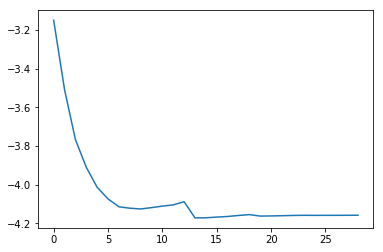

In [25]:
plt.plot(np.log(g.train_history.history['val_loss']))

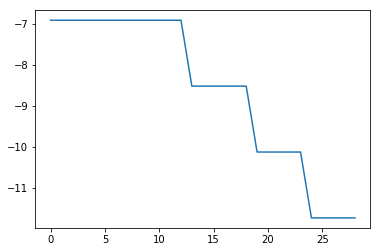

In [26]:
plt.plot(np.log(g.train_history.history['lr']))

## Embedding Visualization

In [1]:
from sklearn import decomposition, manifold

In [27]:
embed_mat.shape

(6510, 100)

In [56]:
DX_embed_mat = embed_mat[:n_DX_cat, :]
PR_embed_mat = embed_mat[np.array([0]+list(range(n_DX_cat, len(code_lst)))), :]

In [57]:
np.save(path+'cohorts/ami/dx_embed_glove.npy', DX_embed_mat)
np.save(path+'cohorts/ami/pr_embed_glove.npy', PR_embed_mat)

In [139]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

In [140]:
DX_tsne = tsne.fit_transform(DX_embed_mat[1:,:])

In [151]:
ami_ccs = multi_ccs.loc[multi_ccs.ICD9CM_CODE.isin(DX_cat)]
ami_ccs = ami_ccs.set_index(ami_ccs.ICD9CM_CODE, drop=True).drop(['ICD9CM_CODE'], axis=1)
ami_ccs['finest_non_empty'] = ami_ccs.CCS_LVL4
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL3[ami_ccs.finest_non_empty == '']
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL2[ami_ccs.finest_non_empty == '']
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL1[ami_ccs.finest_non_empty == '']

In [146]:
ccs_lvl1 = [ami_ccs.loc[c, 'CCS_LVL1'] for c in code_lst[1:(n_DX_cat)]]

In [153]:
fine_group = [ami_ccs.loc[c, 'finest_non_empty'] for c in code_lst[1:(n_DX_cat)]]

In [154]:
plot_df = pd.DataFrame(dict(x=DX_tsne[:, 0], y=DX_tsne[:, 1], lvl1=ccs_lvl1, fine_group=fine_group))

In [80]:
#plot_df = plot_df.assign(level=[len(g.split('.')) for g in plot_df.fine_group])

In [149]:
groups = plot_df.groupby('lvl1')

gkey = groups.groups.keys()

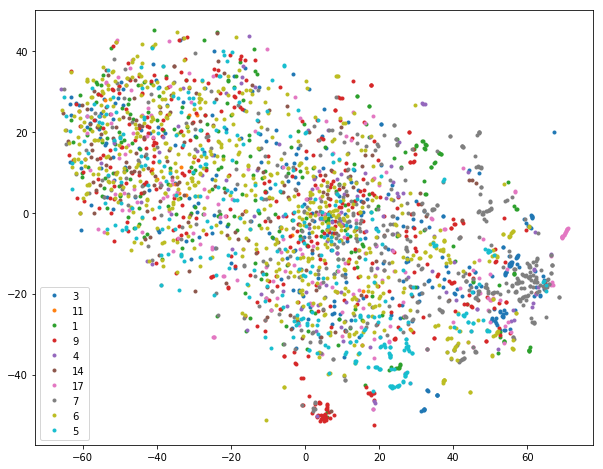

In [150]:
fig, ax = plt.subplots(figsize=(10, 8))
for name in list(gkey)[:10]:
    group = groups.get_group(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [155]:
top_fine_cat = ami_ccs.finest_non_empty.value_counts().iloc[:10].index
plot_subdf = plot_df.loc[plot_df.fine_group.isin(top_fine_cat)]

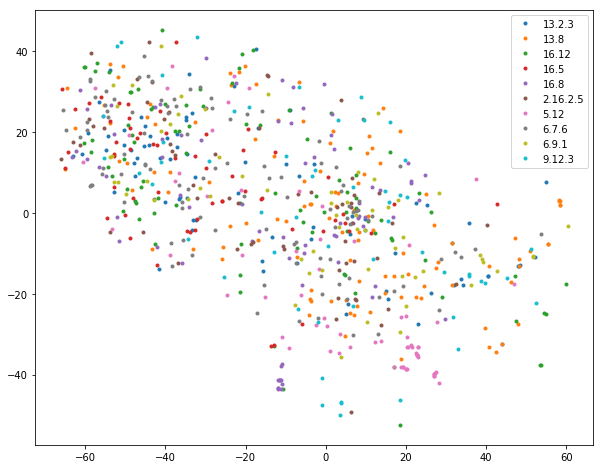

In [156]:
groups = plot_subdf.groupby('fine_group')
fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

## Get the cooccurrences from the whole database

In [1]:
from ccs_tools import dx_multi, pr_multi
from glove import Glove

Using TensorFlow backend.


In [8]:
dx_multi.ICD9CM_CODE.shape, pr_multi.ICD9CM_CODE.shape

((15072,), (3948,))

In [9]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE) + sorted(pr_multi.ICD9CM_CODE)

DX_dict = dict(zip(DX_cat, range(len(DX_cat))))

PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat), len(DX_cat)+len(PR_cat)))))

DXs = ['DX'+str(j) for j in range(1, 31)]
PRs = ['PR'+str(j) for j in range(1, 16)]

In [15]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [10]:
g = Glove(input_dim=len(code_cat), embedding_dim=100)

In [23]:
dtypes = dict(zip(DXs, [bytes]*30))
dtypes.update(zip(PRs, [bytes]*15))

In [27]:
dxpr_df = pd.read_csv(path+'all/dxpr.csv', dtype=dtypes, chunksize=500000)

In [28]:
chunk_id = 0
for df in dxpr_df:
    start = time.time()
    DX_df = df[DXs]
    DX_df = DX_df.fillna('missing')
    DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
    DX_df[DX_df.isin(unclassified)] = 'missing'
    for dx in DXs:
        DX_df[dx] = DX_df[dx].map(DX_dict)
        
    PR_df = df[PRs]
    PR_df = PR_df.fillna('missing')
    PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
    for pr in PRs:
        PR_df[pr] = PR_df[pr].map(PR_dict)
        
    df = pd.concat([DX_df, PR_df], axis=1)
    g.update_cooccur(df)
    print('Chunk {} finished. It takes {:.1f} seconds.'.format(chunk_id, time.time()-start))
    chunk_id += 1

Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 65.5 seconds to update the cooccurrences.
Chunk 0 finished. It takes 74.0 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 65.1 seconds to update the cooccurrences.
Chunk 1 finished. It takes 75.5 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 66.6 seconds to update the cooccurrences.
Chunk 2 finished. It takes 77.7 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...


KeyboardInterrupt: 

In [12]:
cooccur_df = pd.read_csv(path+'all/cooccur_df.csv')

In [13]:
cooccur_df.shape

(12866672, 3)

In [14]:
g.train_glove(cooccur_df=cooccur_df, cache_path=model_path, epochs=20)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Train on 20586675 samples, validate on 5146669 samples
Epoch 1/20
20586675/20586675 [==============================] - 150s 7us/step - loss: 0.2261 - val_loss: 0.0574
Epoch 2/20
20586675/20586675 [==============================] - 144s 7us/step - loss: 0.0438 - val_loss: 0.0421
Epoch 3/20
20586675/20586675 [==============================] - 143s 7us/step - loss: 0.0358 - val_loss: 0.0386
Epoch 4/20
20586675/20586675 [==============================] - 143s 7us/step - loss: 0.0332 - val_loss: 0.0373
Epoch 5/20
20586675/20586675 [==============================] - 144s 7us/step - loss: 0.0319 - val_loss: 0.0366
Epoch 6/20
20586675/20586675 [==============================] - 143s 7us/step - loss: 0.0311 - val_loss: 0.0362
Epoch 7/20
20586675/20586675 [==============================] - 143s 7us/step - loss: 0.0306 - val_loss: 0.0358
Epoch 8/20
20586675/20586675 [==============================] - 143s 7us/step - loss: 0

KeyboardInterrupt: 

In [24]:
embed_mat = g.get_embed_mat()

In [72]:
embed_mat.shape

(6510, 100)

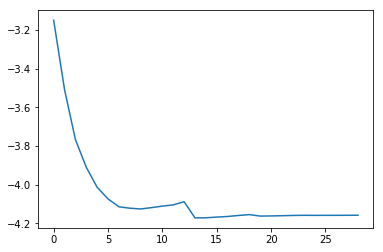

In [25]:
plt.plot(np.log(g.train_history.history['val_loss']))

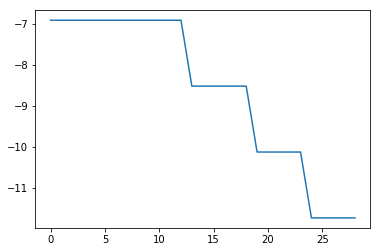

In [26]:
plt.plot(np.log(g.train_history.history['lr']))

### backups

In [30]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)
N_trn = len(trn_df)
N_val = len(val_df)
train_df = pd.concat([trn_df, val_df])